In [2]:
# %pip install catboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

## Загружаем данные

In [4]:
dataset = pd.read_table('/home/jupyter/datasphere/project/Расчёт дискрипторов/dataframe.tsv')
product = pd.read_table('/home/jupyter/datasphere/project/Обработка таргета/vec_prod.tsv')

## Обучение модели

### Формирование таргета

Отберём 500 реакций в тест. Из 1 тыс создадим 500 фейковых реакций путём случайного перемешивания продуктов в реакции

In [5]:
index_test = dataset.sample(500).sort_index().index

In [6]:
dataset_test_pos_neg = dataset.loc[index_test].reset_index(drop = 1)
dataset = dataset.drop(index_test)

In [7]:
product_test_positive = product.loc[index_test].reset_index(drop = 1)
product_test_negative = product_test_positive.sample(frac=1).reset_index(drop = 1)

In [8]:
product = product.drop(index_test)

In [9]:
dataset_test = pd.concat([dataset_test_pos_neg, dataset_test_pos_neg], axis = 0).reset_index(drop = 1)
product_test = pd.concat([product_test_positive, product_test_negative], axis = 0).reset_index(drop = 1)

In [10]:
target_pos = pd.Series([1 for _ in range(len(product_test_positive))])
target_neg = pd.Series([0 for _ in range(len(product_test_positive))])

In [11]:
target_test = pd.concat([target_pos, target_neg], axis = 0).reset_index(drop = 1)

### Обучаем

In [12]:
def tanimoto_similarity(list1, list2):
    intersection = sum(x and y for x, y in zip(list1, list2))
    union = sum(x or y for x, y in zip(list1, list2))
    koef = intersection/union if union != 0 else 0

    return koef

### Глазами смотрим на обучение

In [5]:
def plot_roc_auc(y_test, y_pred_score):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)

    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()

In [23]:
clf = CatBoostClassifier(
    loss_function='Logloss',
    iterations=10000,
    depth= 3,  
    random_seed=42, 
    learning_rate=0.75, 
    custom_loss='AUC',
    eval_metric='AUC',
    task_type="GPU",
    devices='0'
)

In [25]:
vec_mol_test = list(product_test.iloc[0])

koefs = pd.Series(
    [tanimoto_similarity(
        vec_mol_test, 
        list(product.iloc[prod_ind])
    ) for prod_ind in tqdm(range(product.shape[0]))
    ]
)

q90 = koefs.quantile(0.90)
target = koefs.apply(lambda x: 1 if x >= q90 else 0)

X_train, X_val, y_train, y_val = train_test_split(dataset, target, test_size = 0.20)

clf.fit(
    X = X_train,
    y = y_train,
    eval_set=(X_val, y_val),
    verbose = 1,
    # early_stopping_rounds=300,
    plot = True
)

pred = clf.predict_proba(X_val)[:, -1]

100%|██████████| 99500/99500 [00:19<00:00, 5201.19it/s]


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5538410	best: 0.5538410 (0)	total: 9.55ms	remaining: 1m 35s
1:	total: 17.4ms	remaining: 1m 27s
2:	total: 25.1ms	remaining: 1m 23s
3:	total: 32.5ms	remaining: 1m 21s
4:	total: 39.8ms	remaining: 1m 19s
5:	test: 0.6611124	best: 0.6611124 (5)	total: 48.4ms	remaining: 1m 20s
6:	total: 56ms	remaining: 1m 20s
7:	total: 63.5ms	remaining: 1m 19s
8:	total: 71ms	remaining: 1m 18s
9:	total: 78.4ms	remaining: 1m 18s
10:	test: 0.6858803	best: 0.6858803 (10)	total: 87.2ms	remaining: 1m 19s
11:	total: 94.5ms	remaining: 1m 18s
12:	total: 103ms	remaining: 1m 18s
13:	total: 110ms	remaining: 1m 18s
14:	total: 117ms	remaining: 1m 17s
15:	test: 0.6977302	best: 0.6977302 (15)	total: 126ms	remaining: 1m 18s
16:	total: 133ms	remaining: 1m 18s
17:	total: 141ms	remaining: 1m 18s
18:	total: 148ms	remaining: 1m 17s
19:	total: 155ms	remaining: 1m 17s
20:	test: 0.7123594	best: 0.7123594 (20)	total: 163ms	remaining: 1m 17s
21:	total: 170ms	remaining: 1m 17s
22:	total: 177ms	remaining: 1m 16s
23:	total: 184

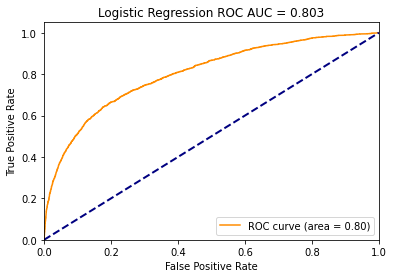

In [26]:
plot_roc_auc(y_val, pred)

<Axes: >

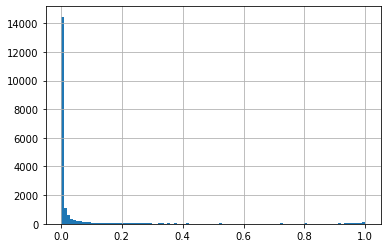

In [27]:
pd.Series(pred).hist(bins = 100)

<Axes: >

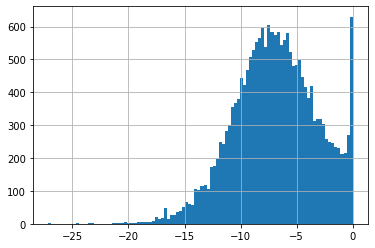

In [28]:
pd.Series(np.log(pred)).hist(bins = 100)

In [29]:
linear_clf = LogisticRegression()
linear_clf.fit(pd.DataFrame(pred), y_val)
pred_linear = linear_clf.predict_proba(pd.DataFrame(pred))[:, -1]

<Axes: >

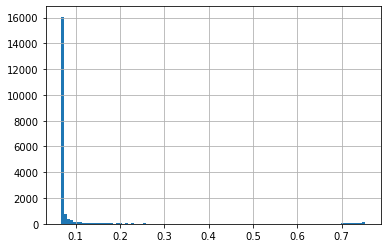

In [30]:
pd.Series(pred_linear).hist(bins = 100)

In [31]:
pd.Series(pred_linear)[pd.Series(pred_linear) > pd.Series(pred_linear).quantile(0.9)]

7        0.423718
11       0.397095
29       0.149548
34       0.131472
50       0.323820
           ...   
19834    0.157363
19838    0.203143
19843    0.668788
19865    0.523785
19870    0.740342
Length: 1990, dtype: float64

In [32]:
linear_clf.coef_

array([[3.761056]])

### Финально на уровне каждой молекулы

In [ ]:
clf = CatBoostClassifier(
    loss_function='Logloss',
    iterations=350,
    depth= 3,  
    random_seed=42, 
    learning_rate=0.75, 
    custom_loss='AUC',
    eval_metric='AUC',
    task_type="GPU",
    devices='0'
)


predict_proba = []

for i in tqdm(range(product_test.shape[0])):
    
    try:
        vec_mol_test = list(product_test.iloc[i])

        koefs = pd.Series(
            [tanimoto_similarity(
                vec_mol_test, 
                list(product.iloc[prod_ind])
            ) for prod_ind in tqdm(range(product.shape[0]))
            ]
        )

        q90 = koefs.quantile(0.90)
        target = koefs.apply(lambda x: 1 if x >= q90 else 0)

        if sum(target) == len(target):
            predict_proba.append(0.0)
            continue
        elif sum(target) == 0:
            predict_proba.append(0.0)
            continue

        clf.fit(
            X = dataset,
            y = target,
            verbose = 0,
            early_stopping_rounds=50,
        )

        pred = clf.predict_proba(pd.DataFrame(dataset_test.iloc[i]).T)[0, -1]
        predict_proba.append(pred)
        
    except:
        predict_proba = [0]

100%|██████████| 99500/99500 [00:19<00:00, 5082.31it/s]
Default metric period is 5 because AUC is/are not implemented for GPU
100%|██████████| 99500/99500 [00:19<00:00, 5126.01it/s]
Default metric period is 5 because AUC is/are not implemented for GPU
100%|██████████| 99500/99500 [00:19<00:00, 5079.70it/s]
Default metric period is 5 because AUC is/are not implemented for GPU
100%|██████████| 99500/99500 [00:19<00:00, 5038.29it/s]
Default metric period is 5 because AUC is/are not implemented for GPU
100%|██████████| 99500/99500 [00:19<00:00, 5084.58it/s]
Default metric period is 5 because AUC is/are not implemented for GPU
100%|██████████| 99500/99500 [00:19<00:00, 5162.72it/s]
Default metric period is 5 because AUC is/are not implemented for GPU
100%|██████████| 99500/99500 [00:19<00:00, 5042.87it/s]
Default metric period is 5 because AUC is/are not implemented for GPU
100%|██████████| 99500/99500 [00:19<00:00, 5059.49it/s]
Default metric period is 5 because AUC is/are not implemented 

In [ ]:
result = pd.DataFrame(zip(predict_proba, list(target_test)), columns = ['proba', 'target'])

In [ ]:
result.to_csv('result.tsv', index = 0, sep = '\t')

In [2]:
res = pd.read_table('result.tsv')
res

proba  target
0    0.994566       1
1    0.852380       1
2    0.771371       1
3    0.902999       1
4    0.473986       1
..        ...     ...
995  0.047639       0
996  0.049108       0
997  0.006600       0
998  0.001272       0
999  0.031522       0

[1000 rows x 2 columns]

In [3]:
roc_auc_score(res.target, res.proba)

0.930558

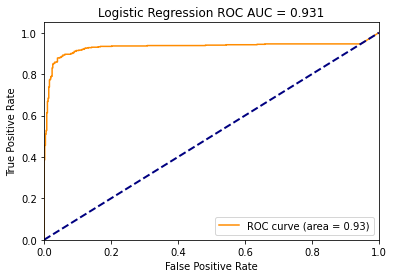

In [6]:
plot_roc_auc(res.target, res.proba)